#   Q18 Machine Learning Rolling Basis

In this example we predict whether the price will rise or fall by using supervised learning (Bayesian Ridge Regression). This template represents a starting point for developing a system which can take part to the **Q18 NASDAQ-100 Stock Long-Short contest**.

It consists of two parts.

* In the **first part** we just perform a global training of the time series using all time series data. We disregard the sequential aspect of the data and use also future data to train past data.

* In the **second part** we use the built-in backtester and perform training and prediction on a rolling basis in order to avoid forward looking. Please note that we are using a **specialized** version of the Quantiacs backtester which dramatically speeds up the the backtesting process by retraining your model on a regular basis.

**Features for learning**: we will use several technical indicators trying to capture different features. You can have a look at [**Technical Indicators**](https://quantiacs.com/documentation/en/user_guide/technical_indicators.html).

Please note that:

* Your trading algorithm can open short and long positions.

* At each point in time your algorithm can trade all or a subset of the stocks which at that point of time are or were part of the NASDAQ-100 stock index. Note that the composition of this set changes in time, and Quantiacs provides you with an appropriate filter function for selecting them.

* The Sharpe ratio of your system since January 1st, 2006, has to be larger than 1.

* Your system cannot be a copy of the current examples. We run a correlation filter on the submissions and detect duplicates.

* For simplicity we will use a single asset. It pays off to use more assets, ideally uncorrelated, and diversify your positions for a more solid Sharpe ratio.

More details on the rules can be found [here](https://quantiacs.com/contest).

**Need help?** Check the [**Documentation**](https://quantiacs.com/documentation/en/) and find solutions/report problems in the [**Forum**](https://quantiacs.com/community/categories) section.

**More help with Jupyter?** Check the official [**Jupyter**](https://jupyter.org/) page.

Once you are done, click on **Submit to the contest** and take part to our competitions.

API reference:

* **data**: check how to work with [data](https://quantiacs.com/documentation/en/reference/data_load_functions.html);

* **backtesting**: read how to run the [simulation](https://quantiacs.com/documentation/en/reference/evaluation.html) and check the results.

Need to use the optimizer function to automate tedious tasks?

* **optimization**: read more on our [article](https://quantiacs.com/community/topic/29/optimizing-and-monitoring-a-trading-system-with-quantiacs).

In [ ]:
# %%javascript
# IPython.OutputArea.prototype._should_scroll = function(lines) { return false; }
# // disable widget scrolling

In [ ]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import logging

import xarray as xr  # xarray for data manipulation

import qnt.data as qndata     # functions for loading data
import qnt.backtester as qnbt # built-in backtester
import qnt.ta as qnta         # technical analysis library
import qnt.stats as qnstats   # statistical functions

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

np.seterr(divide = "ignore")

import xgboost as xgb
from xgboost import XGBClassifier
from qnt.ta.macd import macd
from qnt.ta.rsi  import rsi
from qnt.ta.stochastic import stochastic_k, stochastic, slow_stochastic

from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_absolute_error

In [ ]:
# Load all NASDAQ-100 assets for diversification and robustness

stock_data = qndata.stocks.load_ndx_data(tail = 365 * 5)

fetched chunk 1/2 0s
fetched chunk 2/2 0s
Data loaded 0s


In [ ]:
# Optimal selection of indicators

def get_features(data):
    """Builds the features used for learning:
       * a trend indicator;
       * the moving average convergence divergence;
       * a volatility measure;
       * the stochastic oscillator;
       * the relative strength index;
       * the logarithm of the closing price;
       * the true strength index;
       * the rate of change.
       These features can be modified and new ones can be added easily.
    """

    # trend:
    trend = qnta.roc(qnta.lwma(data.sel(field="close"), 60), 1)

    # Moving Averages
    sma_20 = qnta.sma(data.sel(field="close"), 20)  # NEW: Simple Moving Average (20 days) - Helps smooth out short-term price noise, making it easier to identify the underlying trend. This is useful for reducing false signals in choppy markets.
    ema_20 = qnta.ema(data.sel(field="close"), 20)  # NEW: Exponential Moving Average (20 days) - More responsive to recent price changes, which helps the model react faster to emerging trends. This is particularly useful in fast-moving markets.
    lwma_20 = qnta.lwma(data.sel(field="close"), 20)  # NEW: Linear Weighted Moving Average (20 days) - Assigns more weight to recent prices, making it better at capturing recent price movements. This helps the model adapt quickly to changing market conditions.
    dema_20 = qnta.dema(data.sel(field="close"), 20)  # NEW: Double Exponential Moving Average (20 days) - Reduces lag significantly compared to traditional EMAs, making it more sensitive to price changes. This helps the model identify trends and reversals earlier.

    # Oscillators
    rsi_14 = qnta.rsi(data.sel(field="close"), 14)  # Relative Strength Index (14 days)
    roc_10 = qnta.roc(data.sel(field="close"), 10)  # NEW: Rate of Change (10 days) - Measures the speed of price movements, providing insight into momentum. This helps the model identify when prices are accelerating or decelerating, which can signal potential breakouts or reversals.
    trix_15 = qnta.trix(data.sel(field="close"), 15)  # NEW: TRIX (15 days) - A momentum oscillator that filters out minor price fluctuations, focusing on significant trends. This helps the model avoid noise and focus on meaningful price movements.
    stoch_k, stoch_d = qnta.stochastic(data.sel(field="high"), data.sel(field="low"), data.sel(field="close"), 14)  # Stochastic Oscillator (14 days)

    # volatility:
    volatility = qnta.tr(data.sel(field="high"), data.sel(field="low"), data.sel(field="close"))
    volatility = volatility / data.sel(field="close")
    volatility = qnta.lwma(volatility, 14)

    # the logarithm of the closing price:
    price = data.sel(field="close").ffill("time").bfill("time").fillna(0)
    price = np.log(price)

    # Combine selected features
    result = xr.concat(
        [trend, sma_20, ema_20, lwma_20, dema_20, rsi_14, roc_10, trix_15, stoch_k, stoch_d, volatility, price],
        pd.Index([
            "trend", "sma_20", "ema_20", "lwma_20", "dema_20", "rsi_14", "roc_10", "trix_15", "stoch_k", "stoch_d", "volatility", "price"
        ], name="field")
    )

    return result.transpose("time", "field", "asset")

In [ ]:
# displaying the features:
my_features = get_features(stock_data)
display(my_features.sel(field="trend").to_pandas())

asset,NAS:AAL,NAS:AAPL,NAS:ABNB,NAS:ADBE,NAS:ADCT,NAS:ADI,NAS:ADP,NAS:ADSK,NAS:AEP,NAS:AKAM,...,NYS:JOY,NYS:LEAP,NYS:LVLT,NYS:MWW,NYS:NCLH,NYS:ORCL,NYS:PRGO,NYS:QGEN,NYS:RHT,NYS:TEVA
time,,,,,,,,,,,,,,,,,,,,,
2020-01-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-16,0.569163,-0.130814,-0.066394,-0.389489,NaN,-0.053140,-0.004229,-0.093188,0.044422,-0.198263,...,NaN,NaN,NaN,NaN,0.048034,-0.314059,-0.318059,0.161110,NaN,0.486988
2025-01-17,0.544742,-0.106117,0.007788,-0.361635,NaN,0.013001,-0.005509,-0.077692,0.061599,-0.171672,...,NaN,NaN,NaN,NaN,0.133542,-0.281967,-0.318573,0.164666,NaN,0.514341
2025-01-21,0.597469,-0.204481,-0.041558,-0.310216,NaN,0.049379,0.015324,-0.018030,0.082709,-0.034909,...,NaN,NaN,NaN,NaN,0.110002,-0.059020,-0.238740,0.270208,NaN,0.484724


In [ ]:
def get_target_classes(data):
    """Target classes for predicting if the price will rise (long signal)."""
    # Calculate daily returns
    daily_return = qnta.change(data.sel(field="close")) / data.sel(field="close").shift(time=+1)
    daily_return_future = daily_return.shift(time=-1)  # Future returns (no look-ahead bias)

    # Define threshold for long signal
    move = 0.005  # 0.5% threshold

    # Assign classes:
    # Class 1: Price rises more than +move (long signal)
    # Class 0: Price does not rise (no action)
    target_price = xr.where(daily_return_future > move, 1, 0)

    # Replace NaN and invalid values with 0 (no action)
    target_price = target_price.fillna(0)

    # Ensure integer type
    target_price = target_price.astype(int)

    return target_price

In [ ]:
# displaying the target classes:
my_targetclass = get_target_classes(stock_data)
display(my_targetclass.to_pandas())

asset,NAS:AAL,NAS:AAPL,NAS:ABNB,NAS:ADBE,NAS:ADCT,NAS:ADI,NAS:ADP,NAS:ADSK,NAS:AEP,NAS:AKAM,...,NYS:JOY,NYS:LEAP,NYS:LVLT,NYS:MWW,NYS:NCLH,NYS:ORCL,NYS:PRGO,NYS:QGEN,NYS:RHT,NYS:TEVA
time,,,,,,,,,,,,,,,,,,,,,
2020-01-30,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2020-01-31,1,0,0,1,0,0,1,1,0,0,...,0,0,0,0,1,1,1,0,0,1
2020-02-03,1,1,0,1,0,1,1,1,0,1,...,0,0,0,0,1,1,1,0,0,1
2020-02-04,1,1,0,0,0,1,1,0,0,1,...,0,0,0,0,1,1,0,1,0,0
2020-02-05,0,1,0,1,0,0,1,1,0,1,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-16,0,1,1,1,0,1,0,0,0,1,...,0,0,0,0,1,1,0,0,0,1
2025-01-17,1,0,0,1,0,1,1,1,1,1,...,0,0,0,0,0,1,1,1,0,0
2025-01-21,0,1,0,0,0,1,0,1,0,0,...,0,0,0,0,0,1,0,0,0,1


In [ ]:
def get_model():
    """This is a constructor for the ML model (XGBoost) which can be easily
       modified for using different models.
    """
    # XGBoost is a non-linear model that can capture complex relationships in the data.
    # It is particularly useful for financial data where relationships between features and targets are often non-linear.
    model = XGBClassifier(
        objective='multi:softmax',  # Use 'multi:softmax' for multi-class classification
        num_class=3,                # Number of classes (up, down, neutral)
        n_estimators=100,           # Number of boosting rounds
        max_depth=5,                # Maximum depth of a tree
        learning_rate=0.1,          # Learning rate
        subsample=0.8,              # Subsample ratio of the training instances
        colsample_bytree=0.8,       # Subsample ratio of columns when constructing each tree
        random_state=42             # Random seed for reproducibility
    )
    return model

In [ ]:
# Create and train the models working on an asset-by-asset basis.

asset_name_all = stock_data.coords["asset"].values

models = dict()

for asset_name in asset_name_all:

        # drop missing values:
        target_cur   = my_targetclass.sel(asset=asset_name).dropna(dim="time", how="any")
        features_cur = my_features.sel(asset=asset_name).dropna(dim="time", how="any")

        # align features and targets:
        target_for_learn_df, feature_for_learn_df = xr.align(target_cur, features_cur, join="inner")

        if len(features_cur.time) < 10:
            # not enough points for training
                continue

        model = get_model()

        try:
            model.fit(feature_for_learn_df.values, target_for_learn_df)
            models[asset_name] = model

        except:
            logging.exception("model training failed")

print(models)

{'NAS:AAL': XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None, num_class=3,
              num_parallel_tree=None, ...), 'NAS:AAPL': XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categoric

Feature: 0, Score: 0.08158
Feature: 1, Score: 0.07357
Feature: 2, Score: 0.08614
Feature: 3, Score: 0.09748
Feature: 4, Score: 0.08637
Feature: 5, Score: 0.08100
Feature: 6, Score: 0.08332
Feature: 7, Score: 0.07809
Feature: 8, Score: 0.07823
Feature: 9, Score: 0.08478
Feature: 10, Score: 0.07476
Feature: 11, Score: 0.09468


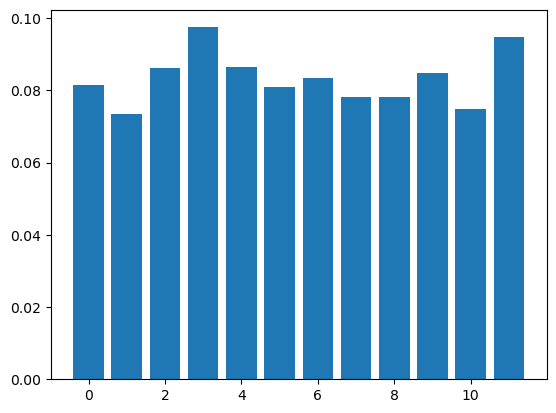

In [ ]:
# Showing which features are more important in predicting:

importance = models["NAS:AAPL"].feature_importances_
importance

for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))

plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [ ]:
# Performs prediction and generates output weights:

asset_name_all = stock_data.coords["asset"].values
weights = xr.zeros_like(stock_data.sel(field="close"))

for asset_name in asset_name_all:
    if asset_name in models:
        model = models[asset_name]
        features_all = my_features
        features_cur = features_all.sel(asset=asset_name).dropna(dim="time", how="any")
        if len(features_cur.time) < 1:
            continue
        try:
            weights.loc[dict(asset=asset_name, time=features_cur.time.values)] = model.predict(features_cur.values)
        except KeyboardInterrupt as e:
            raise e
        except:
            logging.exception("model prediction failed")

print(weights)

<xarray.DataArray 'stocks_nasdaq100' (time: 1253, asset: 280)> Size: 3MB
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * time     (time) datetime64[ns] 10kB 2020-01-30 2020-01-31 ... 2025-01-23
    field    <U5 20B 'close'
  * asset    (asset) <U10 11kB 'NAS:AAL' 'NAS:AAPL' ... 'NYS:RHT' 'NYS:TEVA'


In [ ]:
def get_sharpe(stock_data, weights):
    """Calculates the Sharpe ratio"""
    rr = qnstats.calc_relative_return(stock_data, weights)
    sharpe = qnstats.calc_sharpe_ratio_annualized(rr).values[-1]
    return sharpe

sharpe = get_sharpe(stock_data, weights)
sharpe

152.0928290133819

The sharpe ratio using the method above follows from **forward looking**. Predictions for (let us say) 2017 know about the relation between features and targets in 2020. Let us visualize the results:

In [ ]:
import qnt.graph as qngraph

statistics = qnstats.calc_stat(stock_data, weights)

display(statistics.to_pandas().tail())

performance = statistics.to_pandas()["equity"]
qngraph.make_plot_filled(performance.index, performance, name="PnL (Equity)", type="log")

display(statistics[-1:].sel(field = ["sharpe_ratio"]).transpose().to_pandas())

# check for correlations with existing strategies:
qnstats.print_correlation(weights,stock_data)

field,equity,relative_return,volatility,underwater,max_drawdown,sharpe_ratio,mean_return,bias,instruments,avg_turnover,avg_holding_time
time,,,,,,,,,,,
2025-01-16,8.418634e+06,0.011826,0.156259,0.0,-0.040559,151.309911,23.643471,1.0,218.0,1.357206,1.398068
2025-01-17,8.553628e+06,0.016035,0.156202,0.0,-0.040559,151.463876,23.659019,1.0,218.0,1.357067,1.398380
2025-01-21,8.718016e+06,0.019218,0.156166,0.0,-0.040559,151.698240,23.690043,1.0,218.0,1.356627,1.398504
2025-01-22,8.895496e+06,0.020358,0.156139,0.0,-0.040559,151.958312,23.726594,1.0,218.0,1.356410,1.398952
2025-01-23,9.031945e+06,0.015339,0.156080,0.0,-0.040559,152.092829,23.738695,0.0,218.0,1.356228,1.399645


time,2025-01-23
field,
sharpe_ratio,152.092829



Ok. This strategy does not correlate with other strategies.


In [ ]:
"""R2 (coefficient of determination) regression score function."""
r2_score(my_targetclass, weights, multioutput="variance_weighted")

0.7432035557377296

In [ ]:
"""The explained variance score explains the dispersion of errors of a given dataset"""
explained_variance_score(my_targetclass, weights, multioutput="uniform_average")

0.8083437105400947

In [ ]:
"""The explained variance score explains the dispersion of errors of a given dataset"""
mean_absolute_error(my_targetclass, weights)

0.04451031809371793

Let us now use the Quantiacs **backtester** for avoiding **forward looking**.

The backtester performs some transformations: it trains the model on one slice of data (using only data from the past) and predicts the weights for the following slice on a rolling basis:

In [ ]:
def train_model(data):
    """Create and train the model working on an asset-by-asset basis."""

    asset_name_all = data.coords["asset"].values
    features_all   = get_features(data)
    target_all     = get_target_classes(data)

    models = dict()

    for asset_name in asset_name_all:

        # drop missing values:
        target_cur   = target_all.sel(asset=asset_name).dropna(dim="time", how="any")
        features_cur = features_all.sel(asset=asset_name).dropna(dim="time", how="any")

        target_for_learn_df, feature_for_learn_df = xr.align(target_cur, features_cur, join="inner")

        if len(features_cur.time) < 10:
                continue

        model = get_model()

        try:
            model.fit(feature_for_learn_df.values, target_for_learn_df)
            models[asset_name] = model

        except:
            logging.exception("model training failed")

    return models

In [ ]:
def predict_weights(models, data):
    """Generate weights using predicted class probabilities from XGBoost."""
    asset_name_all = data.coords["asset"].values
    weights = xr.zeros_like(data.sel(field="close"))

    for asset_name in asset_name_all:
        if asset_name in models:
            model = models[asset_name]
            features_all = get_features(data)
            features_cur = features_all.sel(asset=asset_name).dropna(dim="time", how="any")

            if len(features_cur.time) < 1:
                continue  # Skip if no data

            try:
                # Predict probabilities for each class [prob_down, prob_neutral, prob_up]
                proba = model.predict_proba(features_cur.values)

                # Calculate weights as (prob_up - prob_down)
                # This creates a continuous score between -1 (strong short) and +1 (strong long)
                weight_scores = proba[:, 2] - proba[:, 0]

                # Assign scores to weights
                weights.loc[dict(asset=asset_name, time=features_cur.time.values)] = weight_scores

            except Exception as e:
                logging.exception(f"Prediction failed for {asset_name}: {e}")

    # Apply liquidity filter to avoid trading illiquid assets
    is_liquid = data.sel(field='is_liquid')
    weights = weights * is_liquid

    return weights

In [ ]:
# Calculate weights using the backtester:
weights = qnbt.backtest_ml(
    train                         = train_model,
    predict                       = predict_weights,
    train_period                  =  2 *365,  # the data length for training in calendar days
    retrain_interval              = 10 *365,  # how often we have to retrain models (calendar days)
    retrain_interval_after_submit = 1,        # how often retrain models after submission during evaluation (calendar days)
    predict_each_day              = False,    # Is it necessary to call prediction for every day during backtesting?
                                              # Set it to True if you suspect that get_features is looking forward.
    competition_type              = "stocks_nasdaq100",  # competition type
    lookback_period               = 365,                 # how many calendar days are needed by the predict function to generate the output
    start_date                    = "2005-01-01",        # backtest start date
    analyze                       = True,
    build_plots                   = True  # do you need the chart?
)

Run the last iteration...
fetched chunk 1/1 0s
Data loaded 0s
fetched chunk 1/1 0s
Data loaded 0s
Output cleaning...
fix uniq
ffill if the current price is None...
Check liquidity...
Ok.
Check missed dates...
Ok.
Normalization...
Output cleaning is complete.
Write output: /root/fractions.nc.gz
State saved.
---
Run First Iteration...
fetched chunk 1/1 0s
Data loaded 0s
---
Run all iterations...
Load data...
fetched chunk 1/8 0s
fetched chunk 2/8 0s
fetched chunk 3/8 0s
fetched chunk 4/8 0s
fetched chunk 5/8 0s
fetched chunk 6/8 0s
fetched chunk 7/8 0s
fetched chunk 8/8 0s
Data loaded 1s
fetched chunk 1/7 0s
fetched chunk 2/7 0s
fetched chunk 3/7 0s
fetched chunk 4/7 0s
fetched chunk 5/7 0s
fetched chunk 6/7 0s
fetched chunk 7/7 0s
Data loaded 1s
Backtest...


 99% (5046 of 5047) |################### | Elapsed Time: 0:03:34 ETA:   0:00:06

fetched chunk 1/7 0s
fetched chunk 2/7 0s
fetched chunk 3/7 0s
fetched chunk 4/7 0s
fetched chunk 5/7 0s
fetched chunk 6/7 0s
fetched chunk 7/7 0s
Data loaded 1s
Output cleaning...
fix uniq
ffill if the current price is None...
Check liquidity...
Ok.
Check missed dates...
Ok.
Normalization...
Output cleaning is complete.
Write output: /root/fractions.nc.gz
State saved.
---
Analyze results...
Check...
Check liquidity...
Ok.
Check missed dates...
Ok.
Check the sharpe ratio...
Period: 2006-01-01 - 2025-01-23
Sharpe Ratio = -1.1447642687891937


ERROR! The Sharpe Ratio is too low. -1.1447642687891937 < 0.7
Improve the strategy and make sure that the in-sample Sharpe Ratio more than 0.7.


---
Align...
Calc global stats...
---
Calc stats per asset...
Build plots...
---
Select the asset (or leave blank to display the overall stats):


interactive(children=(Combobox(value='', description='asset', options=('', 'NAS:AAL', 'NAS:AAPL', 'NAS:ABNB', …

100% (5047 of 5047) |####################| Elapsed Time: 0:04:02 Time:  0:04:02


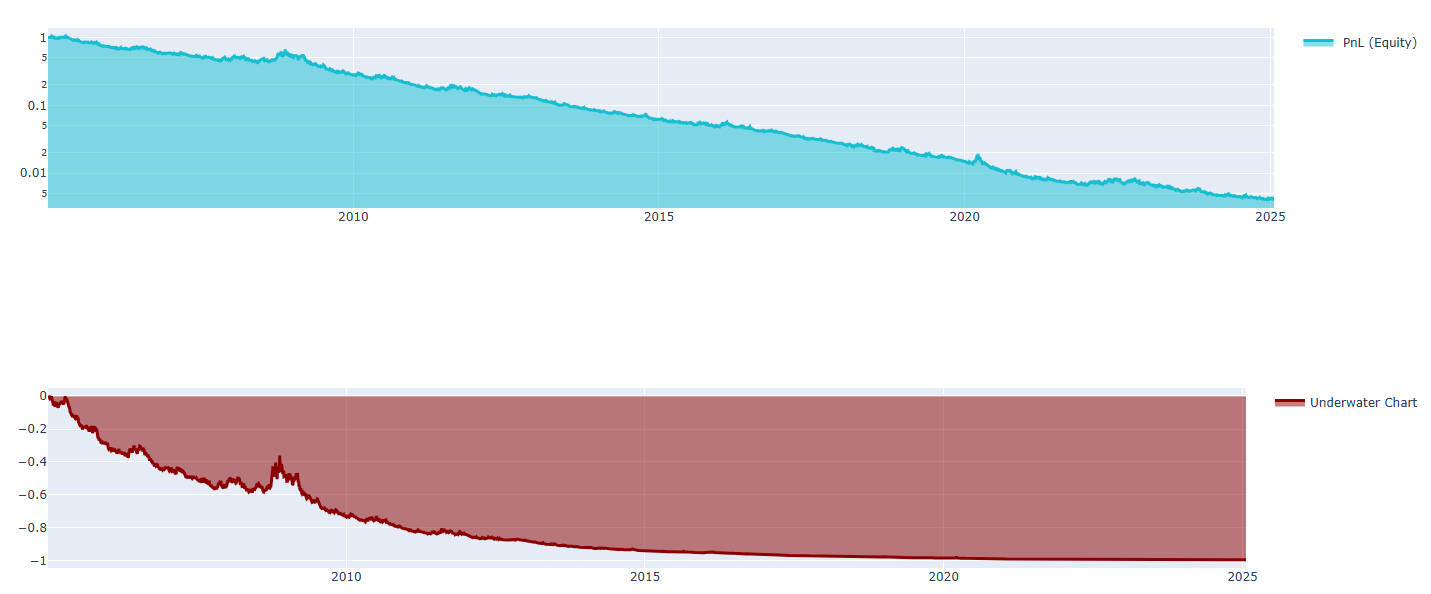
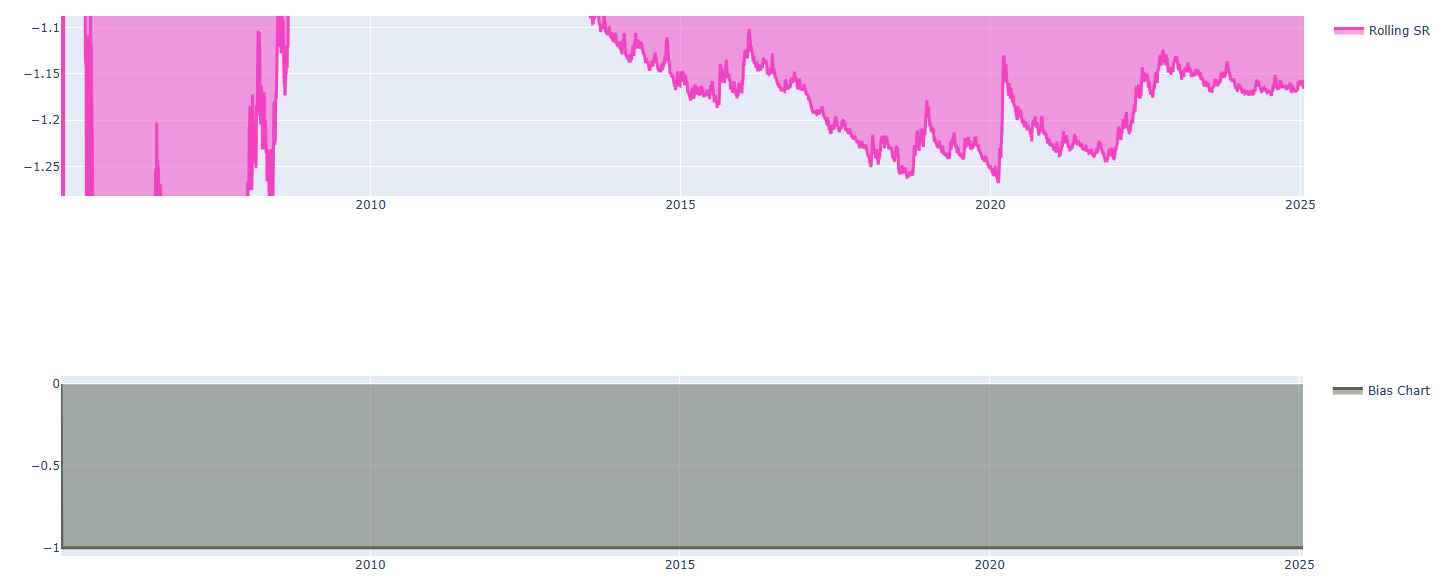

The Sharpe ratio is obviously smaller as the training process is not looking forward (as it happens by processing data on a global basis), but performed on a rolling basis.

# May I import libraries?

Yes, please refer to the file **init.ipynb** in your home directory. You can for example use:

! conda install -y scikit-learn

# How to load data?

Daily stock data for the **Q18 Nasdaq-100** contest can be loaded using:
```python
data = qndata.stocks.load_ndx_data(tail = 17*365, dims = ("time", "field", "asset"))
```

Cryptocurrency daily data used for the Q16/Q17 contests can be loaded using:
```python
data = qndata.cryptodaily.load_data(tail = 17*365, dims = ("time", "field", "asset"))
```

Futures data for the Q15 contest can be loaded using:
```python
data= qndata.futures.load_data(tail = 17*365, dims = ("time", "field", "asset"))
```

BTC Futures data for the Q15 contest can be loaded using:
```python
data= qndata.cryptofutures.load_data(tail = 17*365, dims = ("time", "field", "asset"))
```

# How to view a list of all tickers?

```python
data.asset.to_pandas().to_list()
```

# How to see which fields are available?

```python
data.field.to_pandas().to_list()
```

# How to load specific tickers?

```python
data = qndata.stocks.load_ndx_data(tail=17 * 365, assets=["NAS:AAPL", "NAS:AMZN"])
```

# How to select specific tickers after loading all data?

```python
def get_data_filter(data, assets):
    filler= data.sel(asset=assets)
    return filler

get_data_filter(data, ["NAS:AAPL", "NAS:AMZN"])
```

# How to get the prices for the previous day?

```python
qnta.shift(data.sel(field="open"), periods=1)
```

or:

```python
data.sel(field="open").shift(time=1)
```

# How to get the Sharpe ratio?

```python
import qnt.stats as qnstats

def get_sharpe(market_data, weights):
    rr = qnstats.calc_relative_return(market_data, weights)
    sharpe = qnstats.calc_sharpe_ratio_annualized(rr).values[-1]
    return sharpe

sharpe = get_sharpe(data, weights) # weights.sel(time=slice("2006-01-01",None))
```

# How do I get a list of the top 3 assets ranked by Sharpe ratio?

```python
import qnt.stats as qnstats

data = qndata.stocks.load_ndx_data(tail = 17*365, dims = ("time", "field", "asset"))

def get_best_instruments(data, weights, top_size):
    # compute statistics:
    stats_per_asset = qnstats.calc_stat(data, weights, per_asset=True)
    # calculate ranks of assets by "sharpe_ratio":
    ranks = (-stats_per_asset.sel(field="sharpe_ratio")).rank("asset")
    # select top assets by rank "top_period" days ago:
    top_period = 1
    rank = ranks.isel(time=-top_period)
    top = rank.where(rank <= top_size).dropna("asset").asset

    # select top stats:
    top_stats = stats_per_asset.sel(asset=top.values)

    # print results:
    print("SR tail of the top assets:")
    display(top_stats.sel(field="sharpe_ratio").to_pandas().tail())

    print("avg SR = ", top_stats[-top_period:].sel(field="sharpe_ratio").mean("asset")[-1].item())
    display(top_stats)
    return top_stats.coords["asset"].values

get_best_instruments(data, weights, 3)
```

# How can I check the results for only the top 3 assets ranked by Sharpe ratio?

Select the top assets and then load their data:

```python
best_assets= get_best_instruments(data, weights, 3)

data= qndata.stocks.load_ndx_data(tail = 17*365, assets=best_assets)
```

# How can prices be processed?

Simply import standard libraries, for example **numpy**:

```python
import numpy as np

high= np.log(data.sel(field="high"))
```

# How can you reduce slippage impace when trading?

Just apply some technique to reduce turnover:

```python
def get_lower_slippage(weights, rolling_time=6):
    return weights.rolling({"time": rolling_time}).max()

improved_weights = get_lower_slippage(weights, rolling_time=6)
```

# How to use technical analysis indicators?

For available indicators see the source code of the library: /qnt/ta

## ATR

```python
def get_atr(data, days=14):
    high = data.sel(field="high") * 1.0
    low  = data.sel(field="low") * 1.0
    close= data.sel(field="close") * 1.0

    return qnta.atr(high, low, close, days)

atr= get_atr(data, days=14)
```

## EMA

```python
prices= data.sel(field="high")
prices_ema= qnta.ema(prices, 15)
```

## TRIX

```python
prices= data.sel(field="high")
prices_trix= qnta.trix(prices, 15)
```

## ADL and EMA

```python
adl= qnta.ad_line(data.sel(field="close")) * 1.0
adl_ema= qnta.ema(adl, 18)
```

# How can you check the quality of your strategy?

```python
import qnt.output as qnout
qnout.check(weights, data, "stocks_nasdaq100")
```

or

```python
stat= qnstats.calc_stat(data, weights)
display(stat.to_pandas().tail())
```

or

```python
import qnt.graph   as qngraph
statistics= qnstats.calc_stat(data, weights)
display(statistics.to_pandas().tail())

performance= statistics.to_pandas()["equity"]
qngraph.make_plot_filled(performance.index, performance, name="PnL (Equity)", type="log")

display(statistics[-1:].sel(field = ["sharpe_ratio"]).transpose().to_pandas())
qnstats.print_correlation(weights, data)

```

# An example using pandas

One can work with pandas DataFrames at intermediate steps and at the end convert them to xarray data structures:

```python
def get_price_pct_change(prices):
    prices_pandas = prices.to_pandas()
    assets = data.coords["asset"].values
    for asset in assets:
        prices_pandas[asset] = prices_pandas[asset].pct_change()
    return prices_pandas

prices = data.sel(field="close") * 1.0
prices_pct_change = get_price_pct_change(prices).unstack().to_xarray()
```

# How to submit a strategy to the competition?

Check that weights are fine:

```python
import qnt.output as qnout
qnout.check(weights, data, "stocks_nasdaq100")
```

If everything is ok, write the weights to file:

```python
qnout.write(weights)
```

In your **personal account**:

* **choose** a strategy;
* click on the **Submit** button;
* select the type of competition.

At the beginning you will find the strategy under the **Checking** area:

* **Sent strategies** > **Checking**.

If technical checks are successful, the strategy will go under the **Candidates** area:

* **Sent strategies** > **Candidates**.

Otherwise it will be **Filtered**:

* **Sent strategies** > **Filtered**

and you should inspect error and warning messages.

Note that a strategy under the **Candidates** area should have a Sharpe ratio larger than 1 for being eligible for a prize. Please check warning messages in your **Candidates** area!